In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn import metrics
import torch
import torch.nn as nn
import tensorflow as tf  # pytorch for the model, tensorflow for tokenizer
import gensim

c:\Users\karab\Desktop\turkish-word-embeddings\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [46]:
def read_conllu(path):
    # create a dataframe consisting of word and PoS tag
    sentences = []
    with open(path, 'r', encoding="utf-8") as f:
        data = f.readlines()
        r = len(data)
        i = 0
        while(i < r):
            if(data[i][0] == '#'):
                # two lines
                sentence = []
                pos_representation = []
                i += 2
                while(data[i][0] != '\n'):
                    dt = data[i].strip().split("\t")

                    index = dt[0]
                    word = dt[1]
                    pos = dt[3]
                    pos_representation.append(pos)
                    sentence.append(word)

                    i += 1
                    if('-' in index): i += 2
                i += 1
                sentences.append((sentence, pos_representation))
        return sentences


# read test, dev and train csv files
train = read_conllu("BOUN Dataset/tr_boun-ud-train.conllu")
dev =  read_conllu("BOUN Dataset/tr_boun-ud-dev.conllu")
test =  read_conllu("BOUN Dataset/tr_boun-ud-test.conllu")

import random
sentence, pos_repr = random.choice(train)
print(sentence, ":", pos_repr)


['Ve', 'ben', 'geçtim', '.'] : ['SCONJ', 'PRON', 'VERB', 'PUNCT']


In [47]:

# create a dataframe
traindf = pd.DataFrame(
    {'sentence': [i[0] for i in train],
        'pos': [i[1] for i in train]
    })

testdf = pd.DataFrame(
    {'sentence': [i[0] for i in test],
        'pos': [i[1] for i in test]
    })

devdf = pd.DataFrame(
    {'sentence': [i[0] for i in dev],
        'pos': [i[1] for i in dev]
    })


traindf.head(1), devdf.head(1), testdf.head(1)

(                sentence              pos
 0  [1936, yılındayız, .]  [NUM, _, PUNCT],
                                             sentence   
 0  [Fakülteyi, bitirenler, en, uçtan, göreve, baş...  \
 
                                        pos  
 0  [NOUN, VERB, ADV, NOUN, NOUN, _, PUNCT]  ,
                                             sentence   
 0  [Çünkü, ben, de, o, yaşadığı, çevreyi, kirlete...  \
 
                                                  pos  
 0  [SCONJ, PRON, PART, PRON, VERB, NOUN, VERB, VE...  )

In [48]:
trainx = traindf['sentence']
trainy = traindf['pos']

trainx[0], trainy[0]

(['1936', 'yılındayız', '.'], ['NUM', '_', 'PUNCT'])

In [49]:
# find sentence where one word has tag X
# replace them with tag '_'
for i in range(len(trainx)):
    for j in range(len(trainx[i])):
        if(trainy[i][j] == 'X'):
            print(trainx[i][j], trainy[i][j])
            trainy[i][j] = '_'

| X
batıl X
■ X
tefek X


In [50]:
####### VECTORIZATION #######
word_tokenizer = tf.keras.preprocessing.text.Tokenizer()
word_tokenizer.fit_on_texts(trainx)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(trainx)  # use the tokeniser to encode input sequence

In [51]:
####### VECTORIZATION #######
tag_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tag_tokenizer.fit_on_texts(trainy)                    # fit tokeniser on data
Y_encoded = tag_tokenizer.texts_to_sequences(trainy)  # use the tokeniser to encode input sequence

In [52]:
# make sure that each sequence of input and output is same length

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [53]:
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 130


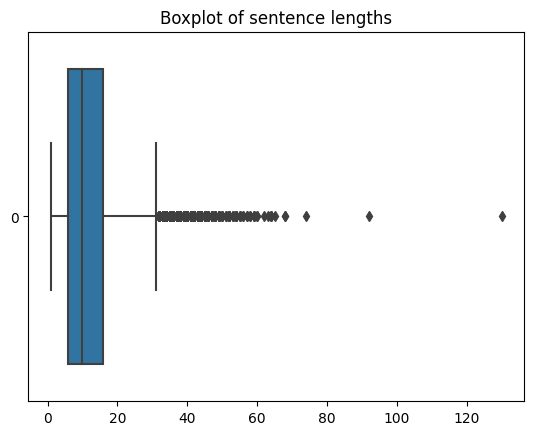

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(lengths, orient='h')
plt.title("Boxplot of sentence lengths")
plt.show()

In [55]:
MAX_SEQ_LENGTH = 130  # sequences greater than MAX_SEQ_LENGTH in length will be truncated

X_padded = tf.keras.preprocessing.sequence.pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [56]:
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 4876 9001    1] 



[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [73]:
MODEL = "C:/Users/karab/Desktop/Models/elmo-Turkish-CoNLL17.wordvectors"

#load fasttext embeddings
print('loading word embeddings...')
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(
            MODEL,
            binary=True,
            no_header=False
        )

loading word embeddings...


In [74]:
EMBEDDING_SIZE  = 1024  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

In [75]:
# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
word2id = word_tokenizer.word_index
for word, index in word2id.items():
    try:  embedding_weights[index, :] = word_vectors[word]
    except KeyError: pass

In [76]:
print("Embeddings shape: {}".format(embedding_weights.shape))

Embeddings shape: (30215, 1024)


In [77]:
Y_final = tf.keras.utils.to_categorical(Y_padded)
# print Y of the first output sequqnce
print(Y_final.shape)  # (number of sequences, length of each sequence, number of tags)

(7803, 130, 17)


In [78]:
### Perform all the operations for dev set ###
devx = devdf['sentence']
devy = devdf['pos']

devx_encoded = word_tokenizer.texts_to_sequences(devx)
devy_encoded = tag_tokenizer.texts_to_sequences(devy)

devx_padded = tf.keras.preprocessing.sequence.pad_sequences(devx_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
devy_padded = tf.keras.preprocessing.sequence.pad_sequences(devy_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

devy_final= tf.keras.utils.to_categorical(devy_padded)

In [79]:
### Perform all the operations for test set ###
testx = testdf['sentence']
testy = testdf['pos']

testx_encoded = word_tokenizer.texts_to_sequences(testx)
testy_encoded = tag_tokenizer.texts_to_sequences(testy)

testx_padded = tf.keras.preprocessing.sequence.pad_sequences(testx_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
testy_padded = tf.keras.preprocessing.sequence.pad_sequences(testy_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

testy_final = tf.keras.utils.to_categorical(testy_padded)

In [80]:
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_padded.shape))
print('Shape of output sequences: {}'.format(Y_final.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(devx_padded.shape))
print('Shape of output sequences: {}'.format(devy_final.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(testx_padded.shape))
print('Shape of output sequences: {}'.format(testy_final.shape))

TRAINING DATA
Shape of input sequences: (7803, 130)
Shape of output sequences: (7803, 130, 17)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (979, 130)
Shape of output sequences: (979, 130, 17)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (979, 130)
Shape of output sequences: (979, 130, 17)


In [81]:
# print unique elements in trainy
print("Unique elements in trainy: {}".format(set([item for sublist in trainy for item in sublist])))
# print unique elements in devy
print("Unique elements in devy: {}".format(set([item for sublist in devy for item in sublist])))
# print unique elements in testy
print("Unique elements in testy: {}".format(set([item for sublist in testy for item in sublist])))

Unique elements in trainy: {'PUNCT', 'VERB', 'CCONJ', 'PART', 'ADJ', 'ADP', 'NOUN', '_', 'INTJ', 'ADV', 'DET', 'PROPN', 'SCONJ', 'PRON', 'AUX', 'NUM'}
Unique elements in devy: {'PUNCT', 'VERB', 'CCONJ', 'PART', 'ADP', 'NOUN', '_', 'INTJ', 'ADV', 'DET', 'ADJ', 'PROPN', 'PRON', 'AUX', 'NUM', 'SCONJ'}
Unique elements in testy: {'PUNCT', 'VERB', 'PART', 'CCONJ', 'ADP', 'NOUN', '_', 'AUX', 'INTJ', 'SCONJ', 'DET', 'ADJ', 'PROPN', 'PRON', 'ADV', 'NUM'}


In [82]:
# total number of tags
NUM_CLASSES = Y_final.shape[2]
NUM_CLASSES

17

In [89]:
# import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation, Dropout

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_weights],
                             trainable     = False
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [90]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [91]:
bidirect_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 130, 1024)         30940160  
                                                                 
 bidirectional_3 (Bidirectio  (None, 130, 128)         557568    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 130, 17)          2193      
 tributed)                                                       
                                                                 
Total params: 31,499,921
Trainable params: 559,761
Non-trainable params: 30,940,160
_________________________________________________________________


In [92]:
bidirect_training = bidirect_model.fit(X_padded, Y_final, batch_size=128, epochs=5, validation_data=(devx_padded, devy_final))

Epoch 1/5
61/61 [==============================] - 6s 55ms/step - loss: 0.6288 - acc: 0.9597 - val_loss: 0.3829 - val_acc: 0.9351
Epoch 2/5
61/61 [==============================] - 2s 36ms/step - loss: 0.0618 - acc: 0.9835 - val_loss: 0.3784 - val_acc: 0.9352
Epoch 3/5
61/61 [==============================] - 2s 35ms/step - loss: 0.0528 - acc: 0.9852 - val_loss: 0.3811 - val_acc: 0.9354
Epoch 4/5
61/61 [==============================] - 2s 35ms/step - loss: 0.0480 - acc: 0.9861 - val_loss: 0.3879 - val_acc: 0.9356
Epoch 5/5
61/61 [==============================] - 2s 35ms/step - loss: 0.0451 - acc: 0.9867 - val_loss: 0.3970 - val_acc: 0.9356


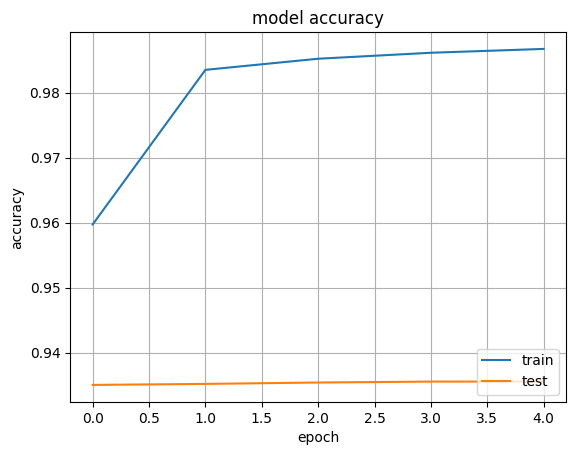

In [93]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [94]:
loss, accuracy = bidirect_model.evaluate(testx_padded, testy_final, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

31/31 [==============================] - 1s 23ms/step - loss: 0.3917 - acc: 0.9367
Loss: 0.3917008638381958,
Accuracy: 0.9367172122001648
